# Loan Investor Demonstration

This document demonstrates the motivations and functionality of the loan investor class. The investors are the primary players that interact with one another and hold, buy and sell loans. They are each assigned a trader and a target score which is their weighted average risk return based on interest rate. The goal of investors in the simulation will be to chase their target score based on a prespecified risk/return profiles. They would start with a random portfolio allocation of loans and then trade to achieve their target score. The simulation is specified in units of cycles which correspond to months in that loans have maturities based on 12 months. The following notebook illustrates some of the key attributes of the loan investor class. 

In [21]:
import Agents.LoanInvestor as LoanInvestor
import Agents.Loan as Loan
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import sys

In [22]:
# creating a set of loans to allocate to investors
loan_list = [Loan.LoanObj() for i in range(1000)]

investor = LoanInvestor.LoanInvestorObj()
investor.initialize_portfolio(loan_list)

In [23]:
vars(investor)

{'id': 'I108dcf36-eeab-4ea4-8dc4-eb4f08b2068a',
 'capital': 47024059.38739191,
 'min_capital_pct': 0.15,
 'capital_history': [47024059.38739191],
 'target_score': 0.24979966541156928,
 'current_score': 0.3761166090457267,
 'current_cycle': 0,
 'loan_fair_values': [14670330.612608094],
 'portfolio_values': [61694390.0],
 'portfolio': [<Agents.Loan.LoanObj at 0x17f21b7c0>,
 'matured_loans': [],
 'trader': None,
 'interest_received': [],
 'loans_for_sale': []}

## Distributions at Play

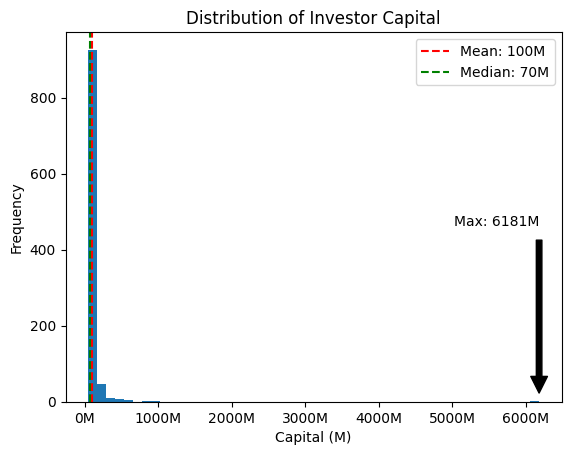

In [24]:
# Generate 1000 random investors
investor_list = [LoanInvestor.LoanInvestorObj() for i in range(1000)]

# Extract the capital for all the investors
capital = [investor.capital for investor in investor_list]

# Plotting the capital and capturing histogram data
n, bins, patches = plt.hist(capital, bins=50)
plt.xlabel("Capital (M)")
plt.ylabel("Frequency")
plt.title("Distribution of Investor Capital")

# Define a custom formatter function for millions
def million_formatter(x, pos):
    return f'{int(x / 1e6)}M'

# Set the custom formatter for the x-axis
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(million_formatter))

# Add vertical lines for mean and median
plt.axvline(np.mean(capital), color='red', linestyle='--', 
            label=f'Mean: {million_formatter(np.mean(capital), 1)}')
plt.axvline(np.median(capital), color='green', linestyle='--', 
            label=f'Median: {million_formatter(np.median(capital), 1)}')

# Find the maximum capital value
max_capital = max(capital)

# Add an annotation for the maximum capital
plt.annotate(f'Max: {million_formatter(max_capital, 1)}', 
             xy=(max_capital, 0), 
             xytext=(max_capital, max(n) * 0.5),
             arrowprops=dict(facecolor='black', shrink=0.05),
             horizontalalignment='right')

plt.legend()
plt.show()


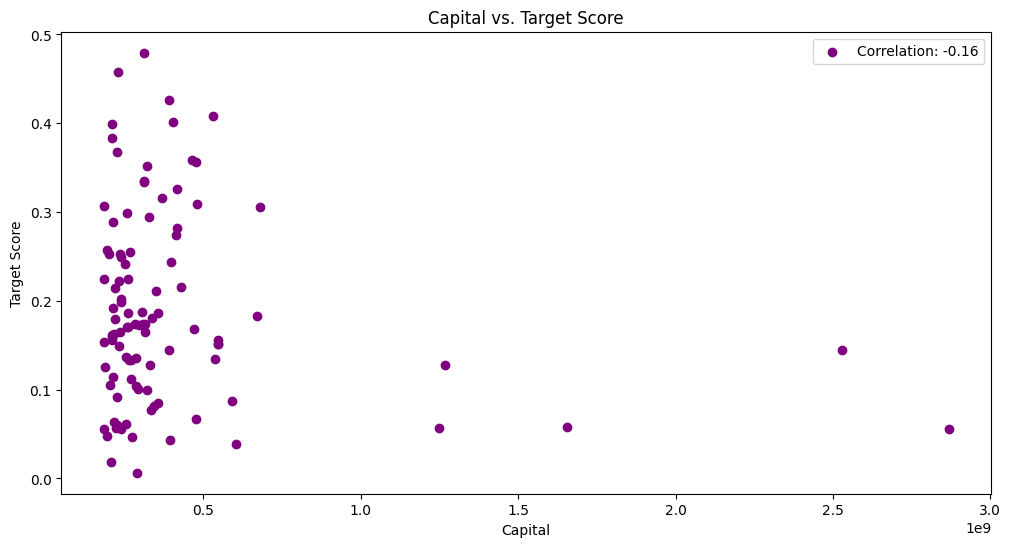

In [25]:
# showing a scatter plot of the relationship between average target score and average capital

investor_list = [LoanInvestor.LoanInvestorObj() for _ in range(1000)]
investor_list_sorted = sorted(investor_list, key=lambda x: x.capital)[900:]

capital = [investor.capital for investor in investor_list_sorted]
target_score = [investor.target_score for investor in investor_list_sorted]

plt.figure(figsize=(12, 6))
plt.scatter(capital, target_score, color='purple', label = f'Correlation: {np.corrcoef(capital, target_score)[0, 1]:.2f}')
plt.xlabel("Capital")
plt.ylabel("Target Score")
plt.title("Capital vs. Target Score")
plt.legend()

## Initial Allocation of Loans

When we are allocating loans to investors, we want to make sure that the loans are allocated in a way that ensures that the number of investors above and below their target score is roughly the same. We tune the parameter for target score to match this target. This can be another aspect to tweak in the simulation to witness the differences when investors have different expectations than potential market reality and what will occur. 

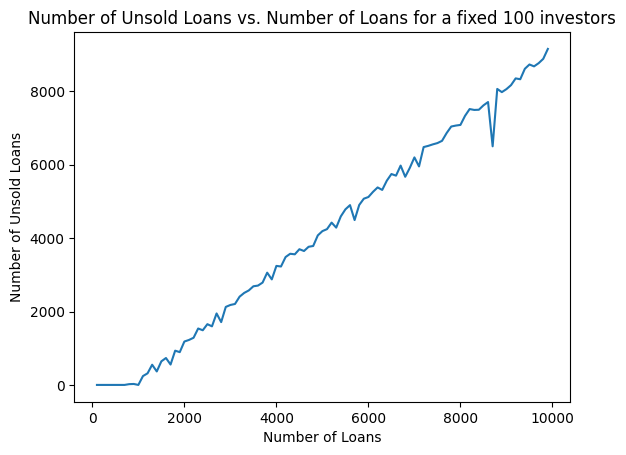

In [26]:
# script false --no-raise-error

def get_unsold_loans(num_loans, num_investors):
    loans = [Loan.LoanObj() for _ in range(num_loans)]
    investors = [LoanInvestor.LoanInvestorObj() for _ in range(num_investors)]

    for investor in investors:
        # regenerating list of available loans
        available_loans = [loan for loan in loans if loan.current_owner == "no owner"]
        investor.generate_initial_capital()
        investor.initialize_portfolio(available_loans)

    unsold_loan_num = len([loan for loan in loans if loan.current_owner == "no owner"])

    return unsold_loan_num


# generating a plot that shows how unsold loans scale with the number of loans versus investors
unsold_loans = [get_unsold_loans(num_loans, 100) for num_loans in range(100, 10000, 100)]
plt.plot(range(100, 10000, 100), unsold_loans)
plt.xlabel("Number of Loans")
plt.ylabel("Number of Unsold Loans")
plt.title("Number of Unsold Loans vs. Number of Loans for a fixed 100 investors")
plt.show()

To ensure that we are using the right parameters for the target score, we are using basic absolute value to ensure the number of investors above and below their target score is roughly the same. This is a simple way to ensure that the market is not too complex and that the investors are not too far off from the market. We can also tune it via the amount of capital above and below the target score, while this is theoretically less accurate since this would vary more from simulation to simulation by virtue of the distribution being used to generate capital, the results end up fairly similar. 

In [27]:
# script false --no-raise-error
def tune_target_score(tuned_target_score, num_simulations=10, tuning_approach = 'amt_capital'):
    num_investors = 100
    num_loans = 1000
    investors_above_list = []
    investors_below_list = []

    for _ in range(num_simulations):
        investor_list = [LoanInvestor.LoanInvestorObj(target_score_param=tuned_target_score) for _ in range(num_investors)]
        loan_list = [Loan.LoanObj() for _ in range(num_loans)]

        for investor in investor_list:
            investor.generate_initial_capital()
            investor.initialize_portfolio([loan for loan in loan_list if loan.current_owner == "no owner"])

        current_scores = np.array([investor.current_score for investor in investor_list])
        target_scores = np.array([investor.target_score for investor in investor_list])
        
        capital = np.array([investor.capital for investor in investor_list])
        
        # getting the amount of capital above and below the target score
        amt_capital_above = sum(capital[i] for i in range(num_investors) if current_scores[i] > target_scores[i])
        amt_capital_below = sum(capital[i] for i in range(num_investors) if current_scores[i] < target_scores[i])

        num_investors_above = np.sum(current_scores > target_scores)
        num_investors_below = np.sum(current_scores < target_scores)

        investors_above_list.append(num_investors_above)
        investors_below_list.append(num_investors_below)

    avg_investors_above = np.mean(investors_above_list)
    avg_investors_below = np.mean(investors_below_list)
    
    avg_capital_above = np.mean(amt_capital_above)
    avg_capital_below = np.mean(amt_capital_below)
    
    if tuning_approach == 'amt_capital':
        return avg_capital_above, avg_capital_below, tuned_target_score
    if tuning_approach == 'num_investors':
        return avg_investors_above, avg_investors_below, tuned_target_score   

param = 0.20
num_iterations = 100

# Tune the target score
for i in range(num_iterations):
    result = tune_target_score(param)
    if result[0] > result[1]:
        param += 0.001
    elif result[0] < result[1]:
        param -= 0.001
    else:
        break

    # Update progress bar
    progress = (i + 1) / num_iterations * 100
    sys.stdout.write(f"\rProgress: {progress:.2f}% | "
                     f"Target Score: {result[2]:.3f} | "
                     f"Above: {result[0]:.2f}, Below: {result[1]:.2f}")
    sys.stdout.flush()

# Print final result on a new line
print(f"\nFinal Tuned Target Score Parameter: {param:.3f}")

Progress: 100.00% | Target Score: 0.205 | Above: 3400428701.76, Below: 3637033965.93
Final Tuned Target Score Parameter: 0.204


Number of investors above target score:  48
Number of investors below target score:  52
Total capital above target score:  3,067,044,122.07
Total capital below target score:  4,082,507,357.85


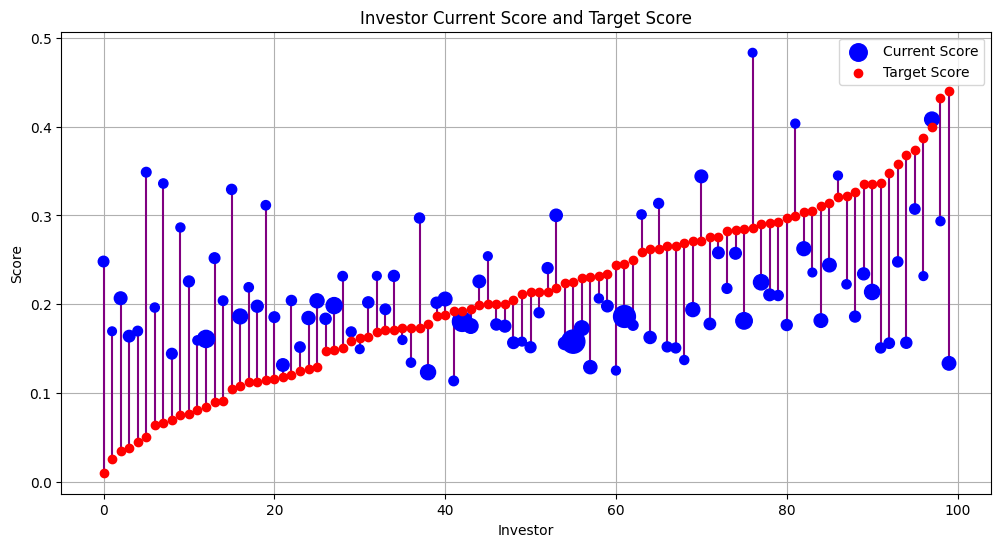

In [28]:
# Creating a universe of investors and loans
num_investors = 100
num_loans = 1000

investor_list = [LoanInvestor.LoanInvestorObj() for i in range(num_investors)]
loan_list = [Loan.LoanObj() for i in range(num_loans)]

# Initializing the investor portfolios
for investor in investor_list:
    investor.generate_initial_capital()
    investor.initialize_portfolio([loan for loan in loan_list if loan.current_owner == "no owner"])

# Extracting the capital, current scores, and target scores
capital = np.array([investor.capital for investor in investor_list])
current_scores = np.array([investor.current_score for investor in investor_list])
target_scores= np.array([investor.target_score for investor in investor_list])

# Sorting the scores and capital for a more organized visualization
indices = np.argsort(target_scores)
current_scores_sorted = current_scores[indices]
target_scores_sorted = target_scores[indices]
capital_sorted = capital[indices]

# Calculating the total capital above and below target score
total_capital_above_target = sum(capital[i] for i in range(num_investors) if current_scores[i] > target_scores[i])
total_capital_below_target = sum(capital[i] for i in range(num_investors) if current_scores[i] < target_scores[i])

# Printing the number of investors and total capital above and below target score
print("Number of investors above target score: ", sum(current_scores > target_scores))
print("Number of investors below target score: ", sum(current_scores < target_scores))
print("Total capital above target score: ", format(total_capital_above_target, ',.2f'))
print("Total capital below target score: ", format(total_capital_below_target, ',.2f'))

# Normalize capital for scatter plot size (adjust scale factor as needed)
size_factor = 0.000001  # Adjust this factor to scale the sizes appropriately
sizes = capital_sorted * size_factor

# Creating the scatter plot with connected lines
plt.figure(figsize=(12, 6))
for i in range(num_investors):
    plt.plot([i, i], [current_scores_sorted[i], target_scores_sorted[i]], color='purple')  # lines
plt.scatter(range(num_investors), current_scores_sorted, s=sizes, color='blue', label='Current Score', zorder=5)
plt.scatter(range(num_investors), target_scores_sorted, color='red', label='Target Score', zorder=5)

plt.ylabel("Score")
plt.xlabel("Investor")
plt.title("Investor Current Score and Target Score")
plt.legend()
plt.grid(True)
plt.show()

In [29]:
trials = 100
num_investors = 100
num_loans = 1000
num_investors_above = []
num_investors_below = []
total_capital_above = []
total_capital_below = []

for _ in range(trials):
    investor_list = [LoanInvestor.LoanInvestorObj() for _ in range(num_investors)]
    loan_list = [Loan.LoanObj() for _ in range(num_loans)]
    
    current_scores = []
    target_scores = []
    capitals = []

    # Initializing the investor portfolios
    for investor in investor_list:
        investor.generate_initial_capital()
        investor.initialize_portfolio([loan for loan in loan_list if loan.current_owner == "no owner"])
        current_scores.append(investor.current_score)
        target_scores.append(investor.target_score)
        capitals.append(investor.capital)

    num_investors_above.append(sum(a > b for a, b in zip(current_scores, target_scores)))
    num_investors_below.append(sum(a < b for a, b in zip(current_scores, target_scores)))

    total_capital_above.append(sum(capital for capital, current_score, target_score in zip(capitals, current_scores, target_scores) if current_score > target_score))
    total_capital_below.append(sum(capital for capital, current_score, target_score in zip(capitals, current_scores, target_scores) if current_score < target_score))

print("Average number of investors above target score: ", np.mean(num_investors_above))
print("Average number of investors below target score: ", np.mean(num_investors_below))
print("Average capital above target score: ", format(np.mean(total_capital_above), ',.2f'))
print("Average capital below target score: ", format(np.mean(total_capital_below), ',.2f'))

Average number of investors above target score:  49.47
Average number of investors below target score:  50.53
Average capital above target score:  4,034,242,738.88
Average capital below target score:  3,830,712,842.32


# Updating: Portfolio and capital over cycles in a non-complex market

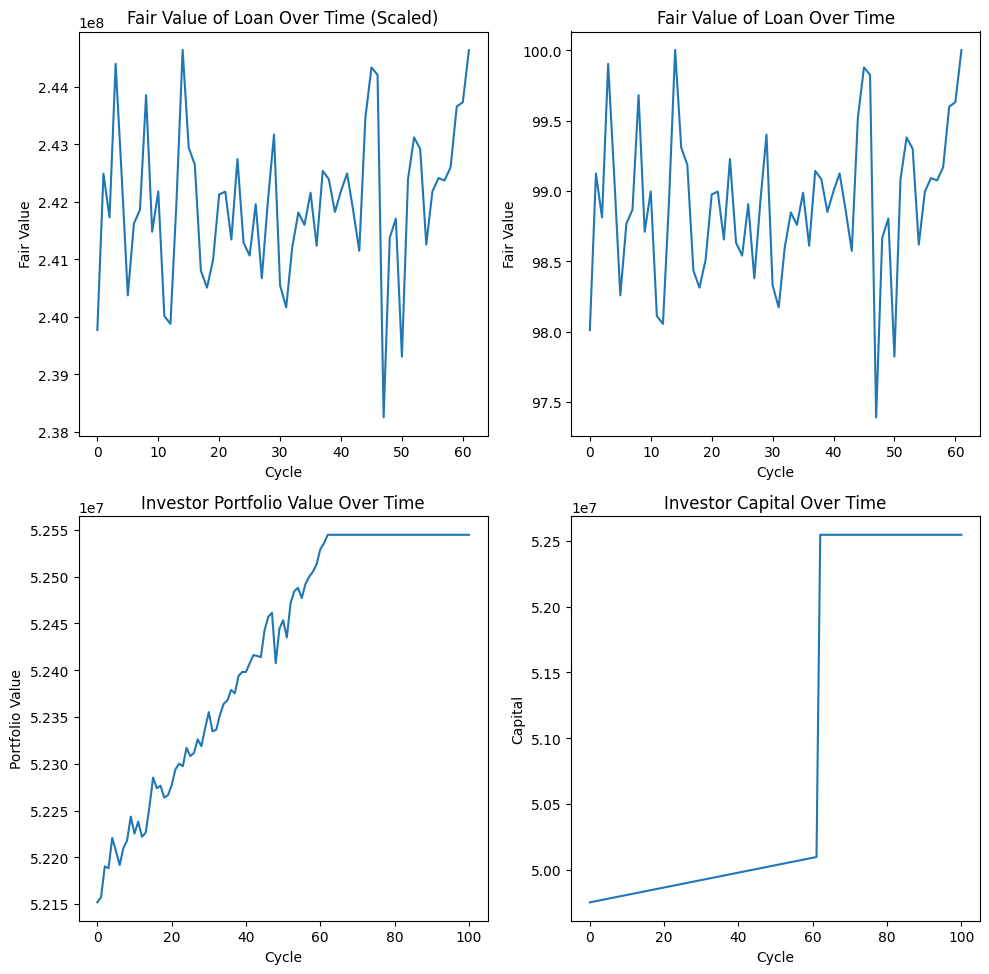

In [30]:
# Creating an investor and a loan
investor = LoanInvestor.LoanInvestorObj()
investor.generate_initial_capital()
loan = Loan.LoanObj()
investor.initialize_portfolio([loan])

# Updating the investor and loan for 100 cycles
for _ in range(100):
    investor.update(cycle=_)
    loan.update(current_cycle=_)

# Creating a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 10))  # Adjust figsize as needed

# Plotting fair value of the loan over time (scaled by size)
axs[0, 0].plot([loan.size * loan.fair_value_history[i] for i in range(len(loan.fair_value_history))])
axs[0, 0].set_title("Fair Value of Loan Over Time (Scaled)")
axs[0, 0].set_xlabel("Cycle")
axs[0, 0].set_ylabel("Fair Value")

# Plotting fair value of the loan over time
axs[0, 1].plot(loan.fair_value_history)
axs[0, 1].set_title("Fair Value of Loan Over Time")
axs[0, 1].set_xlabel("Cycle")
axs[0, 1].set_ylabel("Fair Value")

# Plotting investor portfolio value over time
axs[1, 0].plot(investor.portfolio_values)
axs[1, 0].set_title("Investor Portfolio Value Over Time")
axs[1, 0].set_xlabel("Cycle")
axs[1, 0].set_ylabel("Portfolio Value")

# Plotting investor capital over time
axs[1, 1].plot(investor.capital_history)
axs[1, 1].set_title("Investor Capital Over Time")
axs[1, 1].set_xlabel("Cycle")
axs[1, 1].set_ylabel("Capital")

plt.tight_layout()  # Adjusts the subplots to fit into the figure area
plt.show()

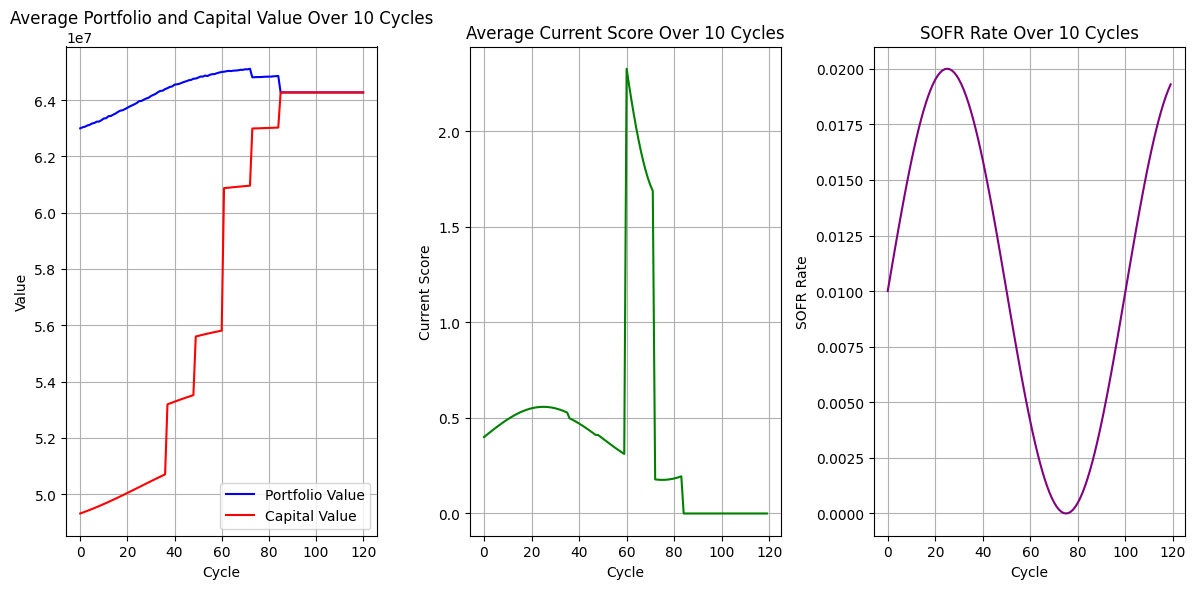

In [31]:
# creating a universe of investors and loans
num_investors = 10
num_loans = 100
cycles = 120

investor_list = [LoanInvestor.LoanInvestorObj() for i in range(num_investors)]
loan_list = [Loan.LoanObj() for i in range(num_loans)]

# initializing the investor portfolios
for investor in investor_list:
    investor.generate_initial_capital()
    investor.initialize_portfolio([loan for loan in loan_list if loan.current_owner == "no owner"])

avg_current_scores = []
portfolio_values = []  
capital_values = []
sofr_rates = [0.01 + 0.01 * np.sin(2 * np.pi * i / 100) for i in range(cycles)]

# Update the market and gather data
for cycle in range(120):
    [loan.update(cycle, float_interest=sofr_rates[cycle]) for loan in loan_list]
    [investor.update() for investor in investor_list]
    avg_current_scores.append(np.mean([investor.current_score for investor in investor_list]))

for investor in investor_list:
    portfolio_values.append(investor.portfolio_values)
    capital_values.append(investor.capital_history)
       
    
# Taking the per cycle average of portfolio and capital
avg_portfolio_values = np.mean(portfolio_values, axis=0)
avg_capital_values = np.mean(capital_values, axis=0)

# Plotting the average portfolio, capital and current score over 10 cycles using subplots
fig, axs = plt.subplots(1, 3, figsize=(12, 6))

# Plotting both portfolio and capital values on the same subplot
axs[0].plot(range(121), avg_portfolio_values, label='Portfolio Value', color='blue')
axs[0].plot(range(121), avg_capital_values, label='Capital Value', color='red')
axs[0].set_title("Average Portfolio and Capital Value Over 10 Cycles")
axs[0].set_ylabel("Value")
axs[0].set_xlabel("Cycle")
axs[0].legend()
axs[0].grid(True)

# Plotting the current score on a separate subplot
axs[1].plot(range(120), avg_current_scores, color='green')
axs[1].set_title("Average Current Score Over 10 Cycles")
axs[1].set_ylabel("Current Score")
axs[1].set_xlabel("Cycle")
axs[1].grid(True)

# Plotting the SOFR rate on a separate subplot
axs[2].plot(range(120), sofr_rates, color='purple')
axs[2].set_title("SOFR Rate Over 10 Cycles")
axs[2].set_ylabel("SOFR Rate")
axs[2].set_xlabel("Cycle")
axs[2].grid(True)


plt.tight_layout()
plt.show()

## Investor Trading: Buying and Selling Loans

The goal of this simulation is to create a plausible market in which investors are individually making intelligent decisions about their loan portfolios. In order to do this, we have investors make decision on selling loans based on deviation of the loans score absent of weight and decide to buy loans based on their 'maximized' price in which the investor takes the attributes of their loan in conjunction with their target score to generate a maximum price that they would be willing to pay for the loan.

### Investor Buying Loans by generating bid prices

In [32]:
# creating a universe of investors and loans
num_investors = 10
num_loans = 100

investor_list = [LoanInvestor.LoanInvestorObj() for i in range(num_investors)]
loan_list = [Loan.LoanObj() for i in range(num_loans)]

# initializing the investor portfolios
for investor in investor_list:
    investor.generate_initial_capital()
    investor.initialize_portfolio([loan for loan in loan_list if loan.current_owner == "no owner"])
    
loan_for_sale = Loan.LoanObj()    
# printing out the relevant information for the loan for sale
print("Loan for Sale: ", (loan_for_sale.as_dict()))

Loan for Sale:  {'id': '5fabcdac-2d82-4527-b16c-b192be23e094', 'maturity': 60, 'current_cycle': 0, 'starting_cycle': 0, 'ending_cycle': 60, 'time_to_maturity': 60, 'pd': 0.014145920762263238, 'size': 4815898.894963679, 'base_interest_rate': 0.011335203514335793, 'interest_rate': 0.011335203514335793, 'fair_value': 100.26675587814607, 'market_price': 100.26675587814607, 'current_owner': 'no owner', 'maturity_bool': False, 'fair_value_history': [100.26675587814607], 'market_price_history': [100.26675587814607], 'ownership_history': ['no owner'], 'sale_price_history': [None], 'reserve_price': 80.21340470251687}


In [33]:
loan_for_sale = Loan.LoanObj()    
# printing out the relevant information for the loan for sale
print("Loan for Sale: ", loan_for_sale.as_dict())

# getting the bid prices for a new loan from every investor using the portfolio weighted method
bid_prices_p_inc = [investor.get_bid_price(loan_for_sale, pricing_method='portfolio_included') for investor in investor_list]
bid_prices_p_n = [investor.get_bid_price(loan_for_sale, pricing_method='portfolio_neutral') for investor in investor_list]

print("\n Bid Prices Portfolio Included: ", bid_prices_p_inc)
print("\n Bid Prices Portfolio Neutral: ", bid_prices_p_n)

Loan for Sale:  {'id': '4de5753f-3a08-4018-964a-23d3e3ee7f33', 'maturity': 84, 'current_cycle': 0, 'starting_cycle': 0, 'ending_cycle': 84, 'time_to_maturity': 84, 'pd': 0.024521533314184524, 'size': 770221.0615905351, 'base_interest_rate': 0.01695824756607348, 'interest_rate': 0.01695824756607348, 'fair_value': 98.62648620160958, 'market_price': 98.62648620160958, 'current_owner': 'no owner', 'maturity_bool': False, 'fair_value_history': [98.62648620160958], 'market_price_history': [98.62648620160958], 'ownership_history': ['no owner'], 'sale_price_history': [None], 'reserve_price': 78.90118896128767}

 Bid Prices Portfolio Included:  [80.93785618943636, 80.66527106667277, 90.5301341101844, 90.42021449522774, -39.161710492971906, 93.5361876535491, 93.2999223327163, 94.25580074219334, 90.99611338028507, 89.0746056050281]

 Bid Prices Portfolio Neutral:  [80.9663478054659, 80.66527106667277, 90.5301341101844, 90.42021449522774, -39.161710492971906, 93.5361876535491, 93.2999223327163, 94

Loan for Sale Pre-update:  {'id': 'f4b44cde-03cd-4591-8269-8b840a072ac8', 'maturity': 84, 'current_cycle': 0, 'starting_cycle': 0, 'ending_cycle': 84, 'time_to_maturity': 84, 'pd': 0.0864637215932612, 'size': 999858.8878398153, 'base_interest_rate': 0.01540612882826631, 'interest_rate': 0.01540612882826631, 'fair_value': 99.92892207980469, 'market_price': 99.92892207980469, 'current_owner': 'no owner', 'maturity_bool': False, 'fair_value_history': [99.92892207980469], 'market_price_history': [99.92892207980469], 'ownership_history': ['no owner'], 'sale_price_history': [None], 'reserve_price': 79.94313766384376}

Loan for Sale post-updates:  [('id', 'f4b44cde-03cd-4591-8269-8b840a072ac8'), ('maturity', 84), ('current_cycle', 84), ('starting_cycle', 0), ('ending_cycle', 84), ('time_to_maturity', 0), ('pd', 0.0864637215932612), ('size', 999858.8878398153), ('base_interest_rate', 0.01540612882826631), ('interest_rate', 0.01540612882826631), ('fair_value', 100), ('market_price', 100), ('cur

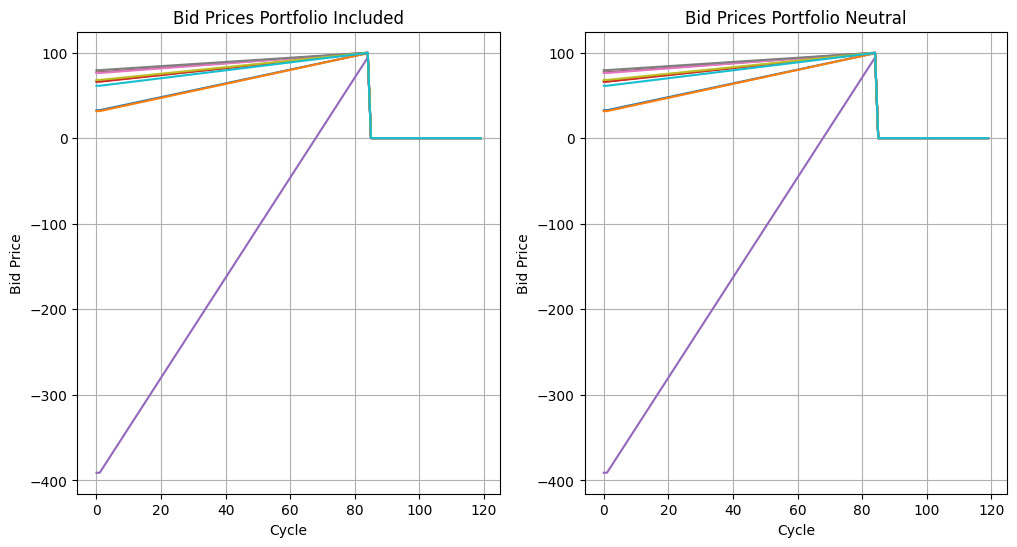

In [34]:
loan_for_sale = Loan.LoanObj(current_cycle=0)    

# printing out the relevant information for the loan for sale
print("Loan for Sale Pre-update: ", loan_for_sale.as_dict())

# plotting bid prices until the loan matures
bid_prices_p_inc = []
bid_prices_p_n = []

cycles = 120

for cycle in range(cycles):
    bid_prices_p_inc.append([investor.get_bid_price(loan_for_sale, pricing_method='portfolio_included') for investor in investor_list])
    bid_prices_p_n.append([investor.get_bid_price(loan_for_sale, pricing_method='portfolio_neutral') for investor in investor_list])
    loan_for_sale.update(current_cycle=cycle)
    [investor.update() for investor in investor_list]

print("\nLoan for Sale post-updates: ", list(loan_for_sale.as_dict().items())[:-2])

print("\n Investor Capital: ", [investor.capital for investor in investor_list] )

# plotting the bid prices over time where each list is a list of lists for each investor as 2 subplots. Each investor is colored differently

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(cycles), bid_prices_p_inc)
plt.title("Bid Prices Portfolio Included")
plt.xlabel("Cycle")
plt.ylabel("Bid Price")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(cycles), bid_prices_p_n)
plt.title("Bid Prices Portfolio Neutral")
plt.xlabel("Cycle")
plt.ylabel("Bid Price")
plt.grid(True)

### Investor getting a loan for sale out of it's portfolio

The basic way that this works is to find the loans that contribute to the current score in the wrong direction by the most possible value. This is completed absent of size where the investors are looking to dump the loans with the largest wrong-way interest rate over size. The reason it is done absent of size is to minimize only the largest loans from being dumped from investors.

In [35]:
# creating a universe of investors and loans
num_investors = 10
num_loans = 100

investor_list = [LoanInvestor.LoanInvestorObj() for i in range(num_investors)]
loan_list = [Loan.LoanObj() for i in range(num_loans)]

# initializing the investor portfolios
for investor in investor_list:
    investor.generate_initial_capital()
    investor.initialize_portfolio([loan for loan in loan_list if loan.current_owner == "no owner"])
    
print('Loan For Sale Attributes', investor_list[0].get_loan_to_sell().as_dict())
print('\nInvestor Attributes', vars(investor_list[0]))

Loan For Sale Attributes {'id': '9ae2708d-4950-42fd-828a-6e784eb38e90', 'maturity': 36, 'current_cycle': 0, 'starting_cycle': 0, 'ending_cycle': 36, 'time_to_maturity': 36, 'pd': 0.11998974100946493, 'size': 4557101.123983098, 'base_interest_rate': 0.011217192668397609, 'interest_rate': 0.011217192668397609, 'fair_value': 99.39332811167154, 'market_price': 99.39332811167154, 'current_owner': <Agents.LoanInvestor.LoanInvestorObj object at 0x17f297340>, 'maturity_bool': False, 'fair_value_history': [99.39332811167154], 'market_price_history': [99.39332811167154], 'ownership_history': ['no owner', 'I90e6fc46-d3fa-49c4-bbff-0552ee719df6'], 'sale_price_history': [None], 'reserve_price': 79.51466248933724}

Investor Attributes {'id': 'I90e6fc46-d3fa-49c4-bbff-0552ee719df6', 'capital': 41590793.2306851, 'min_capital_pct': 0.15, 'capital_history': [41590793.2306851], 'target_score': 0.017006708956780775, 'current_score': 0.1818567059323802, 'current_cycle': 0, 'loan_fair_values': [10184155.769